# TeamVoice를 분석해본다. (두 번째)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

In [22]:
file1 = '../../nmb_data/teamvoice/clear/testvoice_F1(clear).wav'
file2 = '../../nmb_data/teamvoice/clear/testvoice_F1_high(clear).wav'
file3 = '../../nmb_data/teamvoice/clear/testvoice_M2(claer).wav' 

In [23]:
# load audio files with librosa
f1, sr = librosa.load(file1)
f1_high, _ = librosa.load(file2)
m2, _ = librosa.load(file3)

In [24]:
print(len(f1))

110250


# Extracting Short-Time Fourier Transform (STFT)
-  윈도우 크기를 hop_size만큼 건너뛰면서 퓨리에 변환을 해준다.
-  퓨리에 변환 : 시간 영역의 데이터를 주파수 영역으로 변경    
-  아웃풋 : (# of frequency bins, # of frames)
    -  number of frequency bins : FRAM_SIZE / 2 + 1
    -  number of frames : (Samples - FRAM_SIZE) / HOP_SIZE + 1
- FRAM_SIZE가 클수록 -> frequency 해상도 낮아짐, time 해상도 낮아짐
- FRAM_SIZE가 작을수록 -> frequency 해상도 높아짐, time 해상도 높아짐

In [25]:
FRAME_SIZE = 2048
HOP_SIZE = 512

S_f1 = librosa.stft(f1, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
S_f1_high = librosa.stft(f1_high, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
S_m2 = librosa.stft(m2, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
print(S_f1.shape)    
print(type(S_f1[0][0]))

(1025, 216)
<class 'numpy.complex64'>


------

# Calculating the spectrogram
spectrogram = |STFT|^2

(1025, 216)
<class 'numpy.float32'>


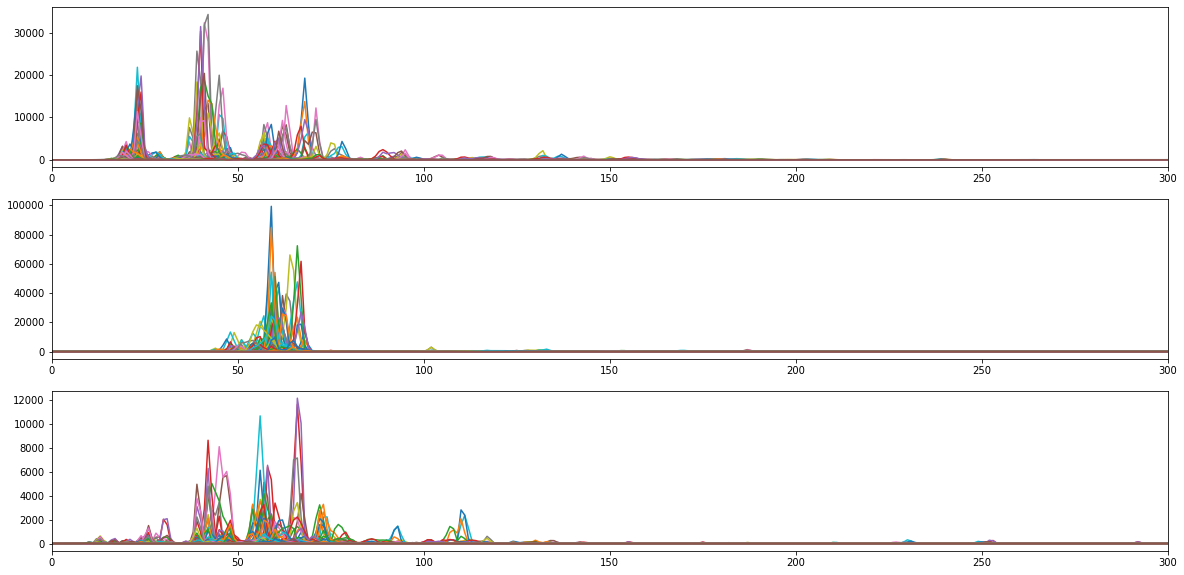

In [48]:
Y_f1 = np.abs(S_f1) ** 2
Y_f1_high = np.abs(S_f1_high) ** 2
Y_m2 = np.abs(S_m2) ** 2

print(Y_f1.shape)
print(type(Y_f1[0][0]))

plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.plot(Y_f1)
plt.xlim((0,300))

plt.subplot(3,1,2)
plt.plot(Y_f1_high)
plt.xlim((0,300))

plt.subplot(3,1,3)
plt.plot(Y_m2)
plt.xlim((0,300))

plt.show()



가로축 : 주파수   
세로축 : power (주파수의 합?)

# Visualizing the spectrogram

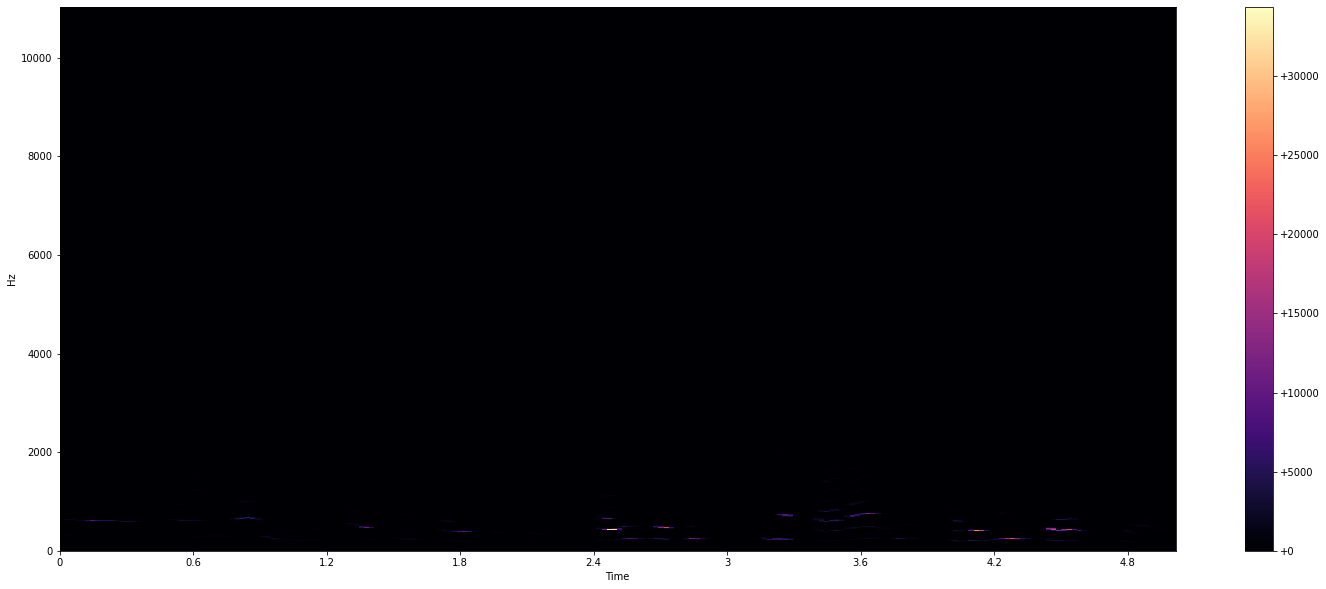

In [49]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,                     # spectogram
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time",         
                             y_axis=y_axis, 
                             )      
    plt.colorbar(format="%+2.f")

plot_spectrogram(Y_f1, sr, HOP_SIZE) 

문제점 : 단순 spectogram 그래프로는 특징을 찾을 수 없다.        
왜? 실제 데이터들이 linear하지 않다.     
해결 : log 스케일이 직관적으로 보기 더 좋다.    

---------

# Log-Amplitude Spectrogram

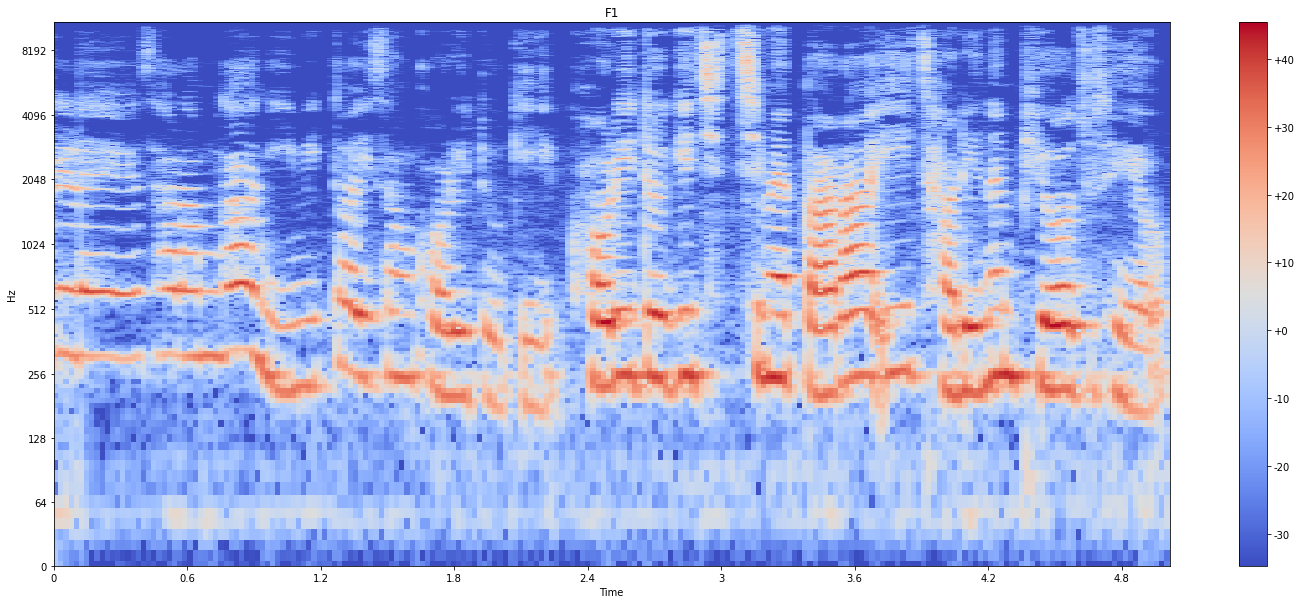

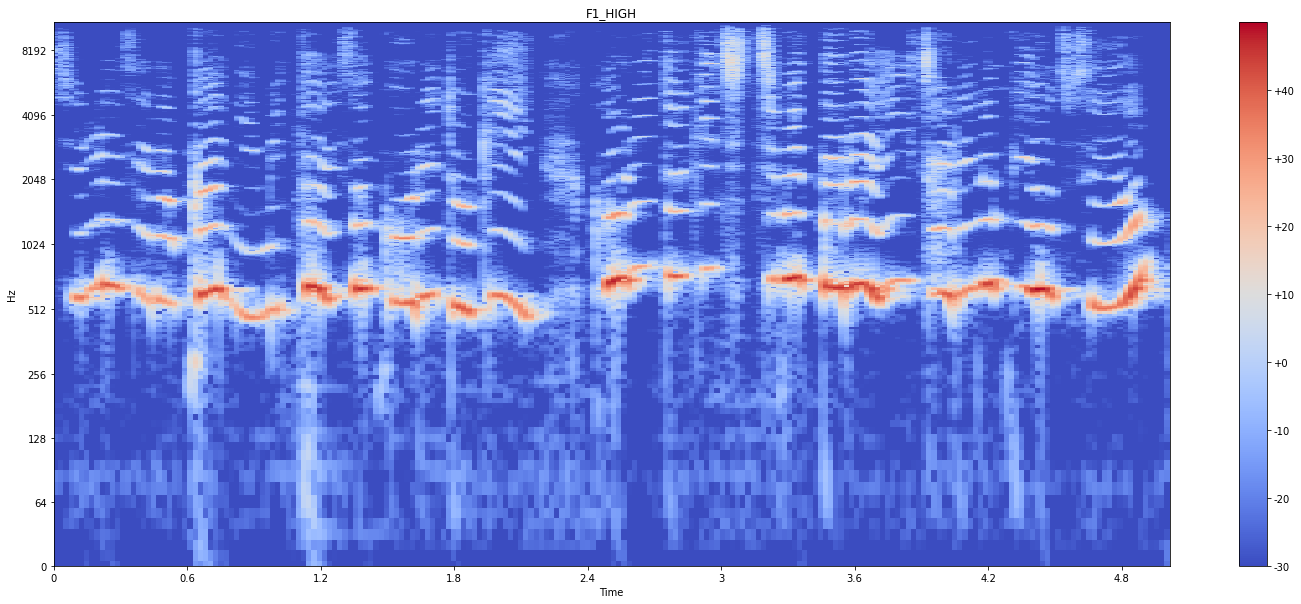

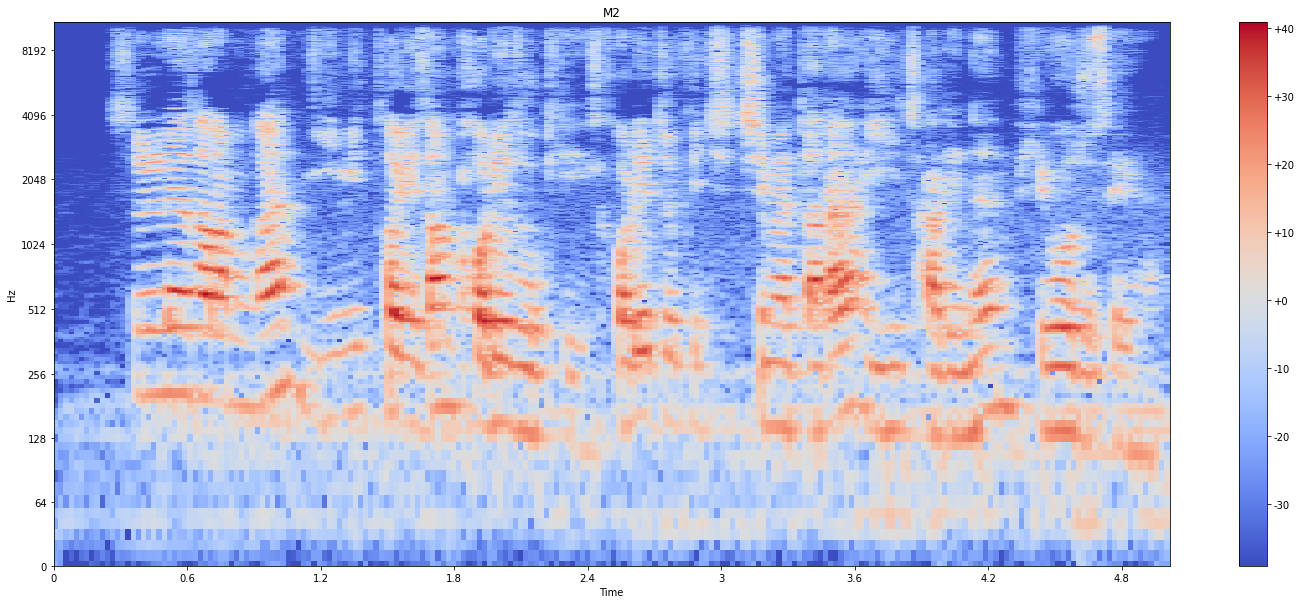

In [28]:
Y_log_f1 = librosa.power_to_db(Y_f1)      # power_to_db : intensity -> db
Y_log_f1_high = librosa.power_to_db(Y_f1_high)      
Y_log_m2 = librosa.power_to_db(Y_m2)     

plot_spectrogram(Y_log_f1, sr, HOP_SIZE, y_axis="log")
plt.title("F1")
plt.show()

plot_spectrogram(Y_log_f1_high, sr, HOP_SIZE, y_axis="log")
plt.title("F1_HIGH")
plt.show()

plot_spectrogram(Y_log_m2, sr, HOP_SIZE, y_axis="log")
plt.title("M2")

plt.show()

가로축 : 시간    
세로축 : Hz (log)    
z축 : dB    

----

# Mel filter banks
인간은 '로그화'된 주파수를 지각하는 것에서 부터 나온 개념

(10, 1025)


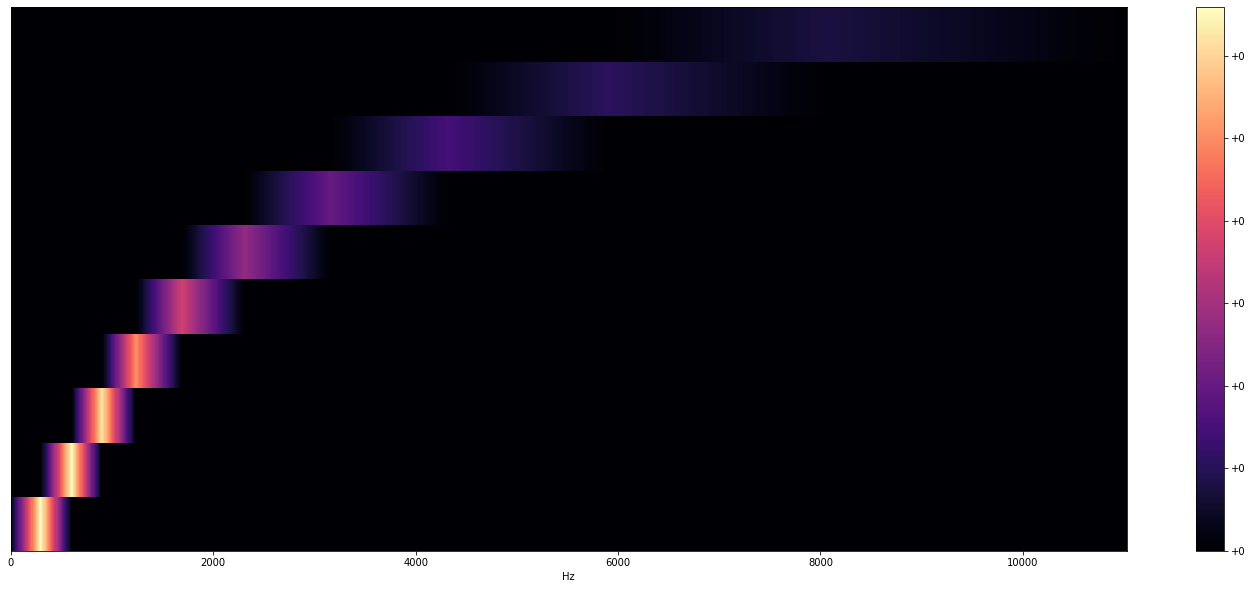

In [29]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
print(filter_banks.shape)

plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

가로축 : Frequency    
세로축 : Mel Frequency   
bands : numbers of mels banks

# Extracting Mel Spectrogram
- 과정
    1.  가장 높은 주파수와 낮은 주파수를 Mel scale로 바꾼다.
    2.  높은 Mel과 낮은 Mel 사이에 n_mels 개수만큼 bands 를 찍는다.
    3.  각 band에서 가까운 주파수들로 반올림시킨다.
    4.  Triangular filter를 적용한다. 

(10, 216)
(10, 216)


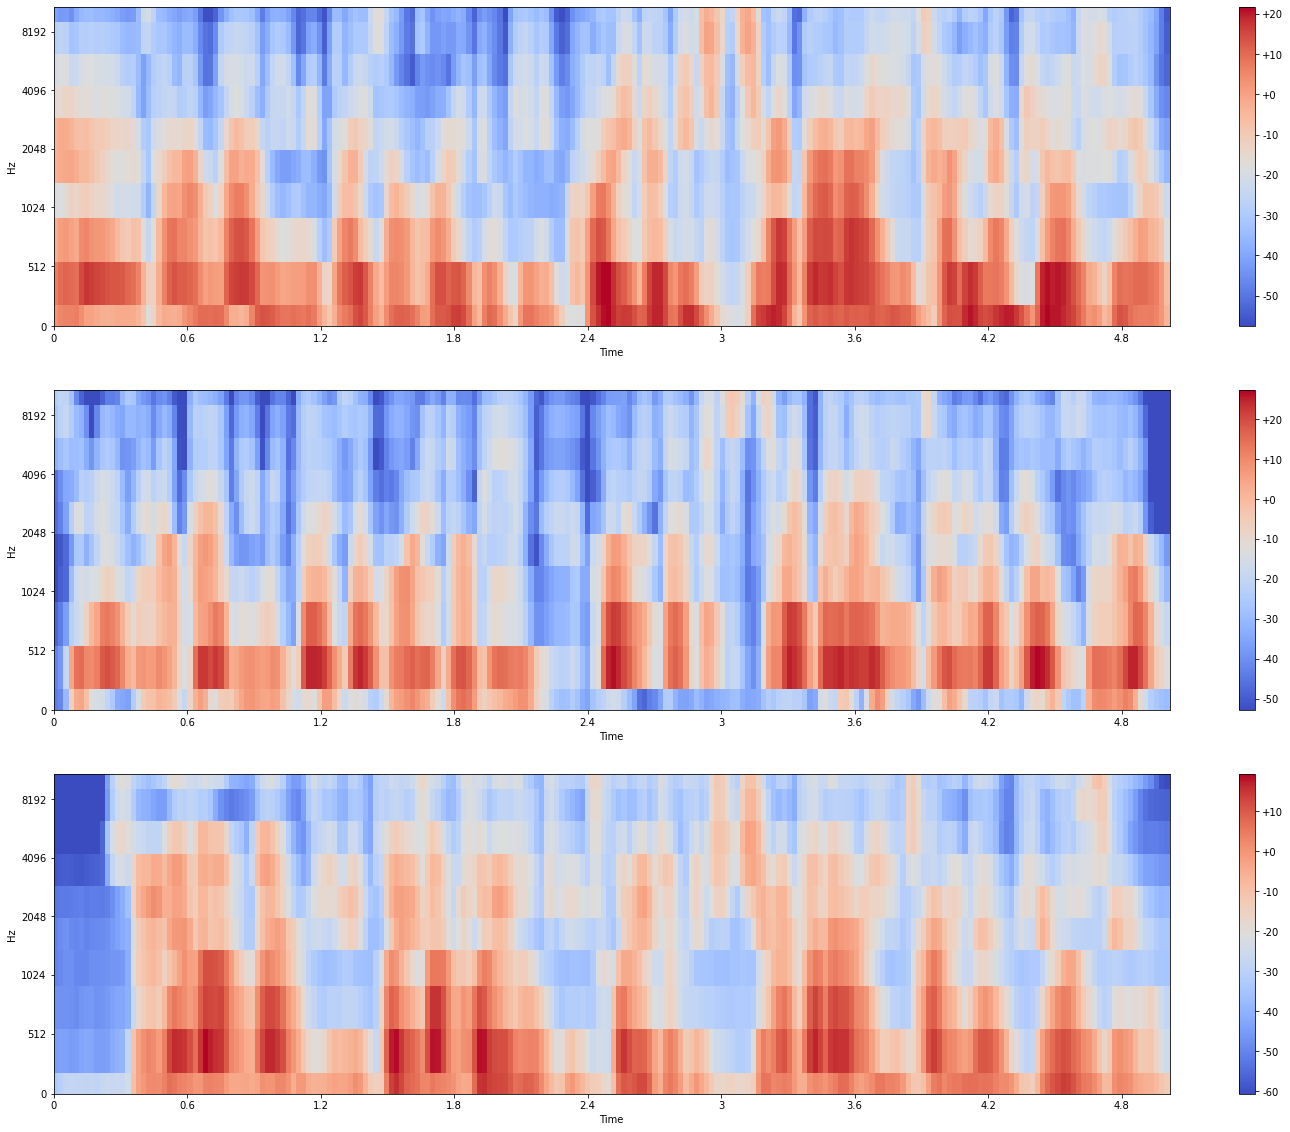

In [30]:
mel_f1 = librosa.feature.melspectrogram(f1, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_f1_high = librosa.feature.melspectrogram(f1_high, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_m2 = librosa.feature.melspectrogram(m2, sr=sr, n_fft=2048, hop_length=512, n_mels=10)

print(mel_f1.shape)
# (10, 216) == (# mel bends, # frames)

log_mel_f1 = librosa.power_to_db(mel_f1)
log_mel_f1_high = librosa.power_to_db(mel_f1_high)
log_mel_m2 = librosa.power_to_db(mel_m2)
print(log_mel_f1.shape)

plt.figure(figsize=(25, 20))
plt.subplot(3, 1, 1)
librosa.display.specshow(log_mel_f1, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(3, 1, 2)
librosa.display.specshow(log_mel_f1_high, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(3, 1, 3)
librosa.display.specshow(log_mel_m2, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(format="%+2.f")

plt.show()

가로축 : 시간    
세로축 : Hz    
z축 : dB

----

# Extracting MFCCs
MFCC ( Mel Frequency Cepstral Coefficients) 
- Cepstral 이란 ?
    + == Cepstrum 
    + == Spectrum of a Spectrum
    + 스펙트럼과 유사한 뜻    
    + 구하는 과정
        1. 오디오 음성 파일
        2. 퓨리에 변환
        3. log 화함 (Mel scale)
        4. 역 퓨리에 변환 (이산 코사인 변환)
    


In [31]:
mfccs_f1 = librosa.feature.mfcc(y=f1, n_mfcc=13, sr=sr)
mfccs_f1_high = librosa.feature.mfcc(y=f1_high, n_mfcc=13, sr=sr)
mfccs_m2 = librosa.feature.mfcc(y=m2, n_mfcc=13, sr=sr)

print(mfccs_f1.shape)
print(mfccs_f1[0][215])
print(mfccs_f1[1][215])

(13, 216)
-371.1192
165.73749


# Visualising MFCCs

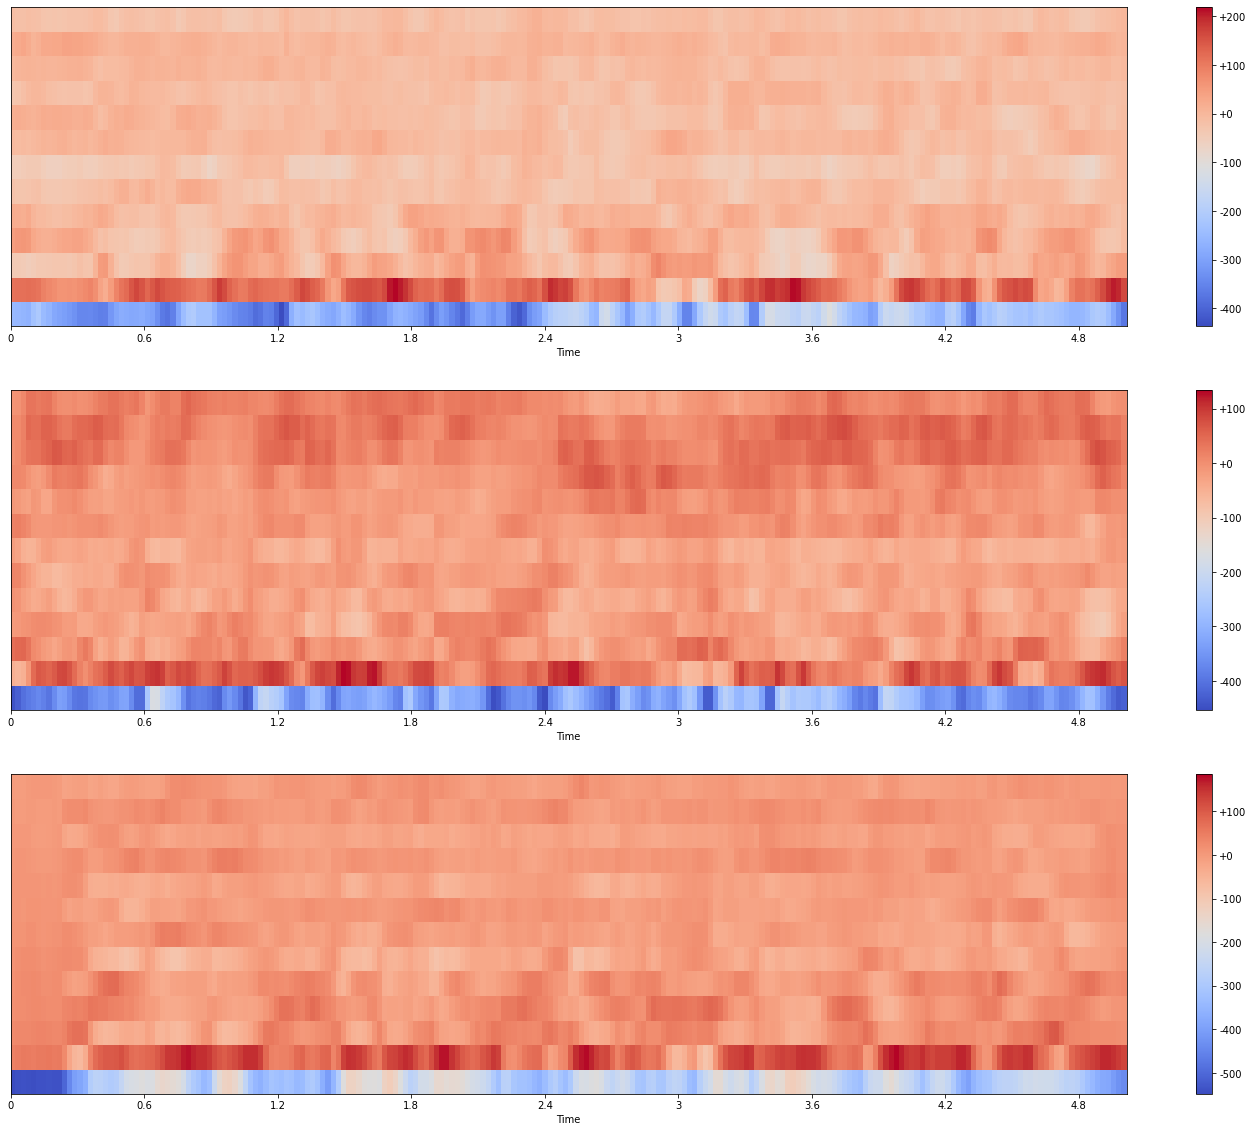

In [32]:
plt.figure(figsize=(25, 20))
plt.subplot(3, 1, 1)
librosa.display.specshow(mfccs_f1, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(3, 1, 2)
librosa.display.specshow(mfccs_f1_high, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(3, 1, 3)
librosa.display.specshow(mfccs_m2, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")

plt.show()

가로축 : time    
세로축 : coeeficient